**Group-08**<br/>
<font style="color:red"> **Belhassen Ghoul <br/> Robin Ehrensperger <br/> Dominic Diedenhofen**</font>

In [72]:
import torch
import numpy as np
import matplotlib.pyplot as plt

## Linear Regression

Using the rent prices from appartments in Lausanne from PW 02, restricting to the feature living area.

### Load Data

In [73]:
import pandas as pd
df = pd.read_csv("lausanne-appart.csv")
N  = df.shape[0]
df.head()

,living_area,nb_rooms,rent_price
0,69,3.0,1810
1,95,3.5,2945
2,21,1.5,685
3,20,1.0,720
4,33,1.5,830


### Normalization

In [74]:
x0 = df.values[:,0]
x = (x0-np.mean(x0))/np.std(x0)
y0 = df.values[:,2]
y = (y0-np.mean(y0))/np.std(y0)

Text(0, 0.5, 'rent_price')

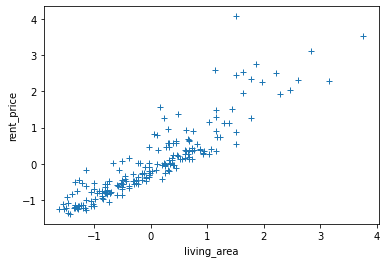

In [75]:
plt.plot(x, y,"+")
plt.xlabel("living_area")
plt.ylabel("rent_price")

### Linear Model, Normal Equations and Solution

We denote the observed rent by $y_j$ (at time $x_j$) and the model rent by $\hat{y}_j$ we assume 

$\qquad \hat{y}_j = \alpha + \beta x_j$

By minimizing the mean squares error

$\qquad C = \frac{1}{2N}\sum_j \left(y_j-\hat{y}_j\right)^2 = C(\alpha,\beta)$

we can fit the straigth line as follows by using the design matrix $X$ and the data vector $Y$, defined by 

$\qquad X = \left(\begin{array}{cc} 1 & x_0 \\ 1 & x_1 \\ \vdots & \vdots \\ 1 & x_{N-1}\end{array}\right), \qquad Y = \left(\begin{array}{c} y_0\\ \vdots \\ y_{N-1}\end{array}\right)$

We find 

$\qquad \left(\begin{array}{c}\alpha \\ \beta\end{array}\right) = \left(X^T\cdot X\right)^{-1}\cdot X^T\cdot Y$

Hence, here we can easily compute the (linear) model which best fits the training data in the sense of obtaining a minimal mean square error. 

### Solution of Normal Equations in Pytorch

C:\Users\Belg\AppData\Local\Temp\ipykernel_11560\1285826389.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Yhat[:,0] = torch.tensor(np.multiply(a[1],X[:,1])+a[0])


Text(0, 0.5, 'rent_price')

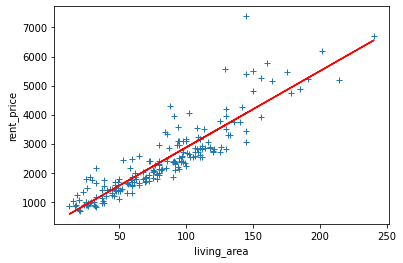

In [76]:
from numpy.linalg import inv
N = x.size

# YOUR CODE (START)
# compose torch tensors X,Y of shape (N,2) and (N,1) respectively
X = torch.empty(N,2)
Y = torch.empty(N,1)
X[:,0] =1
X[:,1]= torch.tensor(data=df["living_area"])
Y[:,0]= torch.tensor(data=df["rent_price"])
# solution of normal equations, 'a' a torch tensor of shape (2,1) that contains parameters alpha and beta, which shall be optimized
theta = np.dot(inv(np.dot(X.T,X)),np.dot(X.T,Y))
a = torch.empty(2,1)
a[0] = theta.item(0)
a[1] = theta.item(1)

# prediction
Yhat = torch.empty(N,1)
Yhat[:,0] = torch.tensor(np.multiply(a[1],X[:,1])+a[0]) 

# YOUR CODE (END)

# plot
plt.plot(X[:,1],Y,"+")
plt.plot(X[:,1],Yhat,'r')
plt.xlabel("living_area")
plt.ylabel("rent_price")

Note that with the pytorch function `torch.lstsq` you can obtain the same.

#### Cost

In [77]:
def cost(X,Y,a):
    # YOUR CODE (START)
    Yhat = torch.empty(N,1)
    Yhat[:,0] = torch.tensor(np.multiply(a[1],X[:,1])+a[0])  
    cost = torch.sum((Y-Yhat)**2)/(2*N)
    return cost
    # YOUR CODE (END)

In [78]:
cost_closed_form = cost(X,Y,a)
print(cost_closed_form)


tensor(138034.9531)


C:\Users\Belg\AppData\Local\Temp\ipykernel_11560\1441382419.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Yhat[:,0] = torch.tensor(np.multiply(a[1],X[:,1])+a[0])


### Gradient Descent

Specify the gradient of the cost (w.r.t. $\alpha, \beta$) here as maths expression.

In [79]:
df["Yhat"] = np.dot(X,a)
df["Yhat"]

0      2057.014648
1      2741.658203
2       793.057495
3       766.725037
4      1109.046875
          ...     
196    3636.961426
197    4453.267090
198    5532.897461
199    6559.862305
200    4058.280518
Name: Yhat, Length: 201, dtype: float32

In [80]:
def gradient_cost(X,Y,a):
    # YOUR CODE (START)
    Yhat[:,0] = torch.tensor(np.multiply(a[1],X[:,1])+a[0])     
    error = Yhat-Y
    
    grad_a = torch.tensor([0.0,0.0], dtype=torch.float64).reshape(2,1)
    grad_a[1] = torch.sum(error*X[:,1])/(2*N)
    grad_a[0] = torch.sum(error)/(2*N)
    return grad_a
    # YOUR CODE (END)

C:\Users\Belg\AppData\Local\Temp\ipykernel_11560\1441382419.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Yhat[:,0] = torch.tensor(np.multiply(a[1],X[:,1])+a[0])
C:\Users\Belg\AppData\Local\Temp\ipykernel_11560\3436099881.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Yhat[:,0] = torch.tensor(np.multiply(a[1],X[:,1])+a[0])


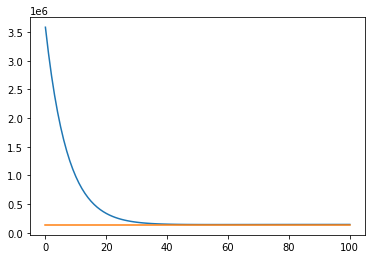

In [94]:
# adjust if needed
nepochs = 100
lr = 0.0000001

## initial parameter
a = torch.tensor([0.0,0.0], dtype=torch.float64).reshape(2,1)

# track the costs
costs = [cost(X,Y,a)]

# YOUR CODE (START)
# loop over the epochs: update parameter values, compute the cost and add it to the costs list
for epoch in range(nepochs):
    grad_a = gradient_cost(X,Y,a)
    a = a-lr*grad_a
    costs.append(cost(X,Y,a))

# YOUR CODE (END)
    
# some output
cost_gd = costs[-1]
plt.plot(range(nepochs+1),costs)
plt.plot(range(nepochs+1),cost_closed_form*torch.ones(nepochs+1))

Cost Gradient:  tensor(145680.0312) 
Cost Calculated:  tensor(138034.9531)


C:\Users\Belg\AppData\Local\Temp\ipykernel_11560\1441382419.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Yhat[:,0] = torch.tensor(np.multiply(a[1],X[:,1])+a[0])
C:\Users\Belg\AppData\Local\Temp\ipykernel_11560\4250400105.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Yhat[:,0] = torch.tensor(np.multiply(a[1],X[:,1])+a[0])


Text(0, 0.5, 'rent_price')

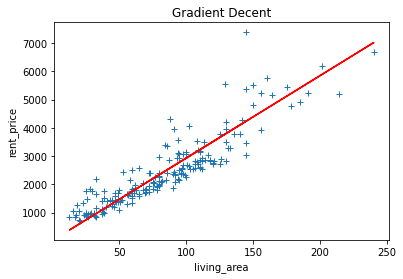

In [95]:
cost_gradient = cost(X,Y,a)
print("Cost Gradient: ", cost_gradient,"\n""Cost Calculated: ", cost_closed_form)

Yhat = torch.empty(N,1)
Yhat[:,0] = torch.tensor(np.multiply(a[1],X[:,1])+a[0]) 

# YOUR CODE (END)

# plot
plt.plot(X[:,1],Y,"+")
plt.plot(X[:,1],Yhat,'r')
plt.title("Gradient Decent")
plt.xlabel("living_area")
plt.ylabel("rent_price")

### Different Learning Rates

Play with different learning rates: Explore for what learning rates 
- the learning is most efficient </br> <font style="color: red">1E-7 to 1E-6 </font>
- the learning yet works </br><font style="color:red"> <1E-7</font>
- the learning does not work anymore (learning rate too large) </br><font style="color:red"> >1E-6 </font>

Explain the different scenarios. </br><font style="color:red">**1st** The learning is most efficient if we get the local minimum in our solution. </br> **2nd** if we choose a very small learning rate and the iteration/epoch will stay the same the algorithm will not reach the local minimum! </br> **3rd** if we overshoot and choose a step size which is to high we can't even reach the local minimum! </font>